# Real estate market research and fraud analysis

## Summary

<div style="border-radius: 15px; border: 3px solid indigo; padding: 15px; font-size: 20px;">
From the dataset of archived ads for the sale of apartments in St. Petersburg and nearby area, we need to determine the market value of real estate properties. 

We need to establish the parameters to build an automated system that detects anomalies and fraudulent activity.

For each apartment listing, there are two types of data available. The first type is provided by the user, and the second type is automatically generated based on cartographic data.
</div>

<strong><em><h1>Step 1 and Step 2. Opening the table and preprocessing the data</em></strong></h1>

<h4><div class="alert alert-block alert-info">
To start, let's import the table and analyze which columns have missing values.</div></h4>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
real = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')
real.tail()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
23694,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.7,5.0,73.3,3,NaN,...,13.83,NaN,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,NaN,5.0,38.0,4,NaN,...,8.50,NaN,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,NaN,3.0,29.7,1,NaN,...,NaN,NaN,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23697,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.0,17.0,NaN,12,NaN,...,23.30,2.0,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0
23698,4,1350000.0,32.30,2017-07-21T00:00:00,1,2.5,5.0,12.3,1,NaN,...,9.00,NaN,поселок Новый Учхоз,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<div class="alert alert-block alert-info">
    <h5>Comments on the table:</h5>
    
1) The total number of rows is 23,699, which is confirmed by the large number of columns with the same count.
    
2) "last price" needs to be converted to an integer format since dealing with decimals in real estate can be confusing.

3) "first_day_exposition" should be converted to a time format and rounded to the nearest day.
    
4) "ceiling_height" has missing values for more than half of the height indicators. We need to find analogs based on the address and fill in the height where possible.
    
5) "floors_total" has a small number of missing values.
    
6) "living_area" has missing values relative to the number of columns. There is a hypothesis that the absence of values in the living area and kitchen area may be related to the boolean parameter "open-plan." If the layout is open-plan, there will be no kitchen or living area.
    
7) "is_apartment" has too few filled values. It is likely that changing the dtype to bool will resolve the issue.
    
8) "kitchen_area" has no missing values. We need to check if they are related to missing values in the living area. There is a hypothesis that in some apartments, the kitchen is combined with the living room, so there is no separate kitchen area. We will investigate further.
    
9) "balcony" has more than half of the values not filled in. Most likely, where there is no balcony, nothing was recorded.
    
10) "locality_name" has a small number of missing values. Since this parameter is important, we will omit the missing values.
    
11) "airport_nearest," "parks_around3000," "ponds_around3000," "parks_nearest," "ponds_nearest," and "cityCenters_nearest" have a large number of missing values, which is likely due to human error during ad posting. I will try to find this information and incorporate it into the table.
    
12) "days_exposition" has almost 3000 missing values. I will try to fill them with the average value of similar objects with a known duration.</div>

<div class="alert alert-block alert-info">
    <h5>Let's start with simple actions:</h5>
2) Changing the data type of "last_price" to int.
7) Changing the data type of "is_apartment" to bool.
</div>

In [4]:
real['is_apartment'] = real['is_apartment'].astype(bool)
real['last_price'] = real['last_price'].astype(int)
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  int64  
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

<div class="alert alert-block alert-info">
3) Converting "first_day_exposition" to a datetime format and rounding it to the nearest day.</div>

In [5]:
real['time_to_day'] = pd.to_datetime(real['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
#real['time_to_day'] = real['first_day_exposition'].real.round('1D')
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19


<div class="alert alert-block alert-info">
Note: Rounding was not necessary since the time was already set to zeros in all cases. The system automatically removed the hours.</div>

<div class="alert alert-block alert-info">
4) "ceiling_height" has a large number of missing values. Let's look for correlations:</div>

In [6]:
real['ceiling_height'].unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [7]:
real['ceiling_height'].loc[real['ceiling_height'] > 5].value_counts()
#.sort_values(by = 'ceiling_height', ascending = True)

27.0     8
25.0     7
8.0      3
5.3      2
32.0     2
14.0     1
5.2      1
6.0      1
8.3      1
5.6      1
5.8      1
10.3     1
5.5      1
20.0     1
26.0     1
22.6     1
27.5     1
24.0     1
100.0    1
Name: ceiling_height, dtype: int64

<div class="alert alert-block alert-info">
By examining the boundary between reasonable and unreasonable values, it appears to fall between 5.2 (an expensive 300 sqm apartment in St. Petersburg) and 5.3 (50 sqm with such high ceilings is unreasonable).
The hypothesis is as follows: values in the range of 20.0 to 32.0 can be explained by incorrect placement of the decimal point, so these values should be corrected by dividing them by 10.</div>

In [8]:
real.query('ceiling_height == 27.0').sort_values(by = 'ceiling_height', ascending = False)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
4876,7,3000000,25.0,2017-09-27T00:00:00,0,27.0,25.0,17.0,17,True,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,28.0,2017-09-27
5246,0,2500000,54.0,2017-10-13T00:00:00,2,27.0,5.0,30.0,3,True,...,2.0,деревня Мины,NaN,NaN,NaN,NaN,NaN,NaN,540.0,2017-10-13
5807,17,8150000,80.0,2019-01-09T00:00:00,2,27.0,36.0,41.0,13,True,...,5.0,Санкт-Петербург,18732.0,20444.0,0.0,NaN,3.0,80.0,38.0,2019-01-09
10773,8,3800000,58.0,2017-10-13T00:00:00,2,27.0,10.0,30.1,3,False,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,71.0,2017-10-13
17857,1,3900000,56.0,2017-12-22T00:00:00,3,27.0,5.0,33.0,4,False,...,NaN,Санкт-Петербург,41030.0,15543.0,0.0,NaN,0.0,NaN,73.0,2017-12-22
20478,11,8000000,45.0,2017-07-18T00:00:00,1,27.0,4.0,22.0,2,True,...,1.0,Санкт-Петербург,18975.0,3246.0,0.0,NaN,3.0,449.0,429.0,2017-07-18
21824,20,2450000,44.0,2019-02-12T00:00:00,2,27.0,2.0,38.0,2,False,...,2.0,городской поселок Большая Ижора,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-02-12
22938,14,4000000,98.0,2018-03-15T00:00:00,4,27.0,2.0,73.0,2,True,...,1.0,деревня Нижняя,NaN,NaN,NaN,NaN,NaN,NaN,27.0,2018-03-15


<div class="alert alert-block alert-info">
In apartments with 27-meter ceilings, nothing unusual was observed - typical area, typical price. Therefore, the hypothesis is confirmed, and we will make the change accordingly.</div>

In [9]:
import numpy as np

In [10]:
#real2 = real['ceiling_height']/10
#real1 = real['ceiling_height'].query>
#real['ceiling_height'] = np.where(real['ceiling_height']>20, real2)
#real.head()
real.loc[real['ceiling_height'] > 23 , 'ceiling_height'] /= 10
real.query('ceiling_height > 23')



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day


<div class="alert alert-block alert-info">
We have eliminated values with human error, but there are still a few values in the range beyond 5.3 that cannot be explained reasonably. Therefore, it is more reliable to "zero" them out and then fill them with the median based on several features.</div>

In [11]:
real_see = real.query('ceiling_height > 5.2').sort_values(by = 'ceiling_height', ascending = False)
real_see

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
20507,12,5950000,60.0,2018-02-19T00:00:00,2,22.6,14.0,35.0,11,True,...,1.0,Санкт-Петербург,27028.0,12570.0,0.0,NaN,0.0,NaN,40.0,2018-02-19
17496,15,6700000,92.9,2019-02-19T00:00:00,3,20.0,17.0,53.2,14,True,...,5.0,Санкт-Петербург,16295.0,15092.0,1.0,967.0,0.0,NaN,NaN,2019-02-19
15061,19,5600000,56.4,2018-05-11T00:00:00,2,14.0,14.0,32.4,5,True,...,2.0,Санкт-Петербург,14814.0,13610.0,0.0,NaN,0.0,NaN,315.0,2018-05-11
22309,20,5300000,45.0,2017-09-30T00:00:00,1,10.3,16.0,15.5,15,True,...,NaN,Санкт-Петербург,36353.0,11936.0,2.0,440.0,2.0,450.0,136.0,2017-09-30
22869,0,15000000,25.0,2018-07-25T00:00:00,1,10.0,5.0,14.0,5,True,...,5.0,Санкт-Петербург,34963.0,8283.0,1.0,223.0,3.0,30.0,19.0,2018-07-25
5863,20,5650000,45.0,2018-08-15T00:00:00,1,8.3,16.0,19.3,14,True,...,1.0,Санкт-Петербург,13069.0,10763.0,0.0,NaN,1.0,613.0,14.0,2018-08-15
3474,3,1400000,30.0,2018-03-16T00:00:00,1,8.0,5.0,15.3,2,False,...,NaN,деревня Нурма,NaN,NaN,NaN,NaN,NaN,NaN,125.0,2018-03-16
15743,14,5600000,67.0,2016-11-11T00:00:00,3,8.0,16.0,41.0,1,True,...,NaN,Санкт-Петербург,32691.0,11035.0,1.0,723.0,0.0,NaN,474.0,2016-11-11
17442,0,5350000,54.0,2015-06-16T00:00:00,2,8.0,5.0,29.0,2,True,...,1.0,Красное Село,24638.0,28062.0,0.0,NaN,0.0,NaN,469.0,2015-06-16
20264,17,119000000,187.6,2017-07-10T00:00:00,4,6.0,7.0,147.0,7,True,...,NaN,Санкт-Петербург,26902.0,5605.0,3.0,484.0,1.0,305.0,259.0,2017-07-10


In [12]:
real['ceiling_height'] = np.where(real.ceiling_height > 5.2, 0, real.ceiling_height)



In [13]:
real['ceiling_height'].isna().sum()

9195

<div class="alert alert-block alert-info">
Thus, we have a large number of NaN values, which we will fill with the mean value.</div>

<div class="alert alert-block alert-info">
We will apply the transform method to several columns with complete data to achieve maximum data recovery.</div>

In [14]:
real['ceiling_height'] = real['ceiling_height'].fillna(real.groupby('total_area')['ceiling_height'].transform('median'))
real.head(8)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.700,16.0,51.0,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.700,11.0,18.6,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.600,5.0,34.3,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.0,2015-07-24T00:00:00,3,3.140,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.030,14.0,32.0,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19
5,10,2890000,30.4,2018-09-10T00:00:00,1,2.520,12.0,14.4,5,True,...,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2018-09-10
6,6,3700000,37.3,2017-11-02T00:00:00,1,2.650,26.0,10.6,6,True,...,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,2017-11-02
7,5,7915000,71.6,2019-04-18T00:00:00,2,2.775,24.0,NaN,22,True,...,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2019-04-18


In [15]:
real['ceiling_height'].isna().sum()

627

In [16]:
real['ceiling_height'] = real['ceiling_height'].fillna(real.groupby('rooms')['ceiling_height'].transform('median'))
real[['last_price','total_area','ceiling_height']].head(15)

,last_price,total_area,ceiling_height
0,13000000,108.00,2.700
1,3350000,40.40,2.700
2,5196000,56.00,2.600
3,64900000,159.00,3.140
4,10000000,100.00,3.030
5,2890000,30.40,2.520
6,3700000,37.30,2.650
7,7915000,71.60,2.775
8,2900000,33.16,2.600
9,5400000,61.00,2.500


In [17]:
real['ceiling_height'].isna().sum()

1

In [18]:
real['ceiling_height'].unique()

array([2.7  , 2.6  , 3.14 , 3.03 , 2.52 , 2.65 , 2.775, 2.5  , 2.67 ,
       2.56 , 2.65 , 3.05 , 2.75 , 2.725, 2.9  , 2.8  , 2.53 , 2.55 ,
       3.   , 3.2  , 2.675, 2.61 , 2.565, 3.25 , 3.45 , 2.77 , 2.85 ,
       2.64 , 2.57 , 4.15 , 3.5  , 2.585, 2.625, 2.725, 3.3  , 2.71 ,
       4.   , 2.47 , 2.59 , 2.73 , 2.84 , 3.1  , 2.58 , 2.34 , 2.555,
       3.4  , 3.06 , 2.72 , 2.54 , 2.51 , 2.78 , 2.575, 2.76 , 3.7  ,
       5.2  , 2.825, 3.33 , 2.87 , 2.66 , 2.   , 2.755, 2.985, 3.11 ,
       2.45 , 3.6  , 2.69 , 2.92 , 3.355, 2.545, 2.605, 3.13 , 3.8  ,
       3.15 , 3.55 , 2.74 , 3.16 , 2.875, 3.62 , 2.525, 3.12 , 2.53 ,
       2.62 , 2.96 , 2.46 , 0.   , 2.535, 5.   , 2.79 , 2.615, 2.95 ,
       3.125, 4.06 , 2.94 , 3.82 , 3.54 , 2.915, 3.53 , 2.83 , 3.04 ,
       4.7  , 2.4  , 3.38 , 3.01 , 3.65 , 3.025, 3.9  , 2.635, 3.18 ,
       3.35 , 2.3  , 3.57 , 2.48 , 2.82 , 2.57 , 2.63 , 3.98 , 2.85 ,
       2.655, 3.83 , 3.52 , 3.95 , 2.975, 3.75 , 2.88 , 3.67 , 2.505,
       3.87 , 3.66 ,

<div class="alert alert-block alert-info">
There are still values of 0 and 1 remaining in the column, which are clearly not reasonable. However, since there are not many of them, we will simply remove them.</div>

In [19]:
real = real.query('ceiling_height > 2.2 ')

In [20]:
real.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
0,20,13000000,108.00,2019-03-07T00:00:00,3,2.700,16.0,51.00,8,True,...,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,2019-03-07
1,7,3350000,40.40,2018-12-04T00:00:00,1,2.700,11.0,18.60,1,True,...,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,2018-12-04
2,10,5196000,56.00,2015-08-20T00:00:00,2,2.600,5.0,34.30,4,True,...,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20
3,0,64900000,159.00,2015-07-24T00:00:00,3,3.140,14.0,NaN,9,True,...,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24
4,2,10000000,100.00,2018-06-19T00:00:00,2,3.030,14.0,32.00,13,True,...,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19
5,10,2890000,30.40,2018-09-10T00:00:00,1,2.520,12.0,14.40,5,True,...,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,2018-09-10
6,6,3700000,37.30,2017-11-02T00:00:00,1,2.650,26.0,10.60,6,True,...,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,2017-11-02
7,5,7915000,71.60,2019-04-18T00:00:00,2,2.775,24.0,NaN,22,True,...,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,2019-04-18
8,20,2900000,33.16,2018-05-23T00:00:00,1,2.600,27.0,15.43,26,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,2018-05-23
9,18,5400000,61.00,2017-02-26T00:00:00,3,2.500,9.0,43.60,7,True,...,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,2017-02-26


In [21]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23579 non-null  float64       
 7   living_area           21767 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
Now, the number of variables in the "ceiling_height_tran" column matches the number of rows.</div>

5) Let`s refine "floors_total" column

In [22]:
real['floors_total'].isna().sum()

86

<div class="alert alert-block alert-info">
There are a few missing values in the "floors_total" column, but let's check the adequacy of the entered data.</div>

In [23]:
real['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., nan, 20.,
       28., 36., 21., 35., 34., 60.,  1., 29., 33., 52.])

<div class="alert alert-block alert-info">
Apart from the missing values, everything looks realistic, so we can simply replace them.</div>


In [24]:
real['floors_total'] = real['floors_total'].fillna(real.groupby('floor')['floors_total'].transform('median'))
real['floors_total'].unique()

array([16., 11.,  5., 14., 12., 26., 24., 27.,  9.,  6., 17., 25.,  3.,
       23., 19., 18.,  4., 22.,  8.,  2., 10.,  7., 13., 15., 20., 28.,
       36., 21., 35., 34., 60.,  1., 29., 33., 52.])

In [25]:
real['floors_total'].isna().sum()

0

In [26]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23665 non-null  float64       
 7   living_area           21767 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
Now there are no missing values in the "floors_total" column, so we can continue.</div>

In [27]:

real['living_area'].isna().sum()



1898

<div class="alert alert-block alert-info">
6) Let's remove the missing values in the "living_area" column.</div>

In [28]:
real['living_area'] = real['living_area'].fillna(real.groupby('total_area')['living_area'].transform('median'))
real['living_area'].isna().sum()

142

In [29]:
real['living_area'] = real['living_area'].fillna(real.groupby('rooms')['living_area'].transform('median'))
real['living_area'].isna().sum()

0

In [30]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23665 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23665 non-null  int64         
 1   last_price            23665 non-null  int64         
 2   total_area            23665 non-null  float64       
 3   first_day_exposition  23665 non-null  object        
 4   rooms                 23665 non-null  int64         
 5   ceiling_height        23665 non-null  float64       
 6   floors_total          23665 non-null  float64       
 7   living_area           23665 non-null  float64       
 8   floor                 23665 non-null  int64         
 9   is_apartment          23665 non-null  bool          
 10  studio                23665 non-null  bool          
 11  open_plan             23665 non-null  bool          
 12  kitchen_area          21397 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
I applied the transform method twice to achieve complete replacement of missing values.</div>

<div class="alert alert-block alert-info">
8) We fill in the missing values in the "kitchen_area" column using the transform method based on the "total_area" column.</div>

In [31]:
real['kitchen_area'].isna().sum()

2268

In [32]:
real[real['kitchen_area'].isna()].query('studio == True')['kitchen_area'].fillna(0)

144      0.0
440      0.0
608      0.0
697      0.0
716      0.0
        ... 
22867    0.0
22877    0.0
23210    0.0
23554    0.0
23637    0.0
Name: kitchen_area, Length: 148, dtype: float64

In [33]:
real[real['kitchen_area'].isna()].query('studio == True')['kitchen_area'].isna().sum()

148

In [34]:
real['kitchen_area'] = real['kitchen_area'].fillna(real.groupby('total_area')['kitchen_area'].transform('median'))
real['kitchen_area'].isna().sum()

204

In [35]:
real['kitchen_area'] = real['kitchen_area'].fillna(real.groupby('living_area')['kitchen_area'].transform('median'))
real['kitchen_area'].isna().sum()

24

In [36]:
real[real['kitchen_area'].isna()]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
155,8,96000000,317.00,2017-07-07T00:00:00,4,3.50,3.0,183.00,3,True,...,1.0,Санкт-Петербург,22673.0,1771.0,2.0,508.0,3.0,366.0,62.0,2017-07-07
440,8,2480000,27.11,2018-03-12T00:00:00,0,2.70,17.0,24.75,4,True,...,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,2018-03-12
1588,3,1900000,21.89,2018-11-01T00:00:00,1,2.60,19.0,10.93,17,True,...,NaN,посёлок Бугры,NaN,NaN,NaN,NaN,NaN,NaN,22.0,2018-11-01
3311,3,2385000,24.62,2018-11-22T00:00:00,1,2.60,19.0,15.61,17,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,32.0,2018-11-22
3618,16,4000000,75.03,2014-12-15T00:00:00,2,2.53,3.0,66.22,3,True,...,0.0,Всеволожск,NaN,NaN,NaN,NaN,NaN,NaN,588.0,2014-12-15
3836,15,6700000,41.82,2018-11-22T00:00:00,1,2.60,14.0,17.03,14,True,...,NaN,Санкт-Петербург,18893.0,4358.0,0.0,NaN,1.0,665.0,26.0,2018-11-22
4998,4,3720000,26.60,2018-09-20T00:00:00,1,2.60,22.0,13.27,4,True,...,NaN,Санкт-Петербург,35756.0,9329.0,0.0,NaN,1.0,379.0,40.0,2018-09-20
7577,11,2000000,20.60,2018-09-19T00:00:00,1,2.60,18.0,10.55,17,True,...,NaN,Никольское,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-09-19
7921,1,2204000,27.55,2019-04-01T00:00:00,1,2.75,12.0,16.41,12,True,...,2.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,7.0,2019-04-01
8737,0,2900000,27.36,2016-03-25T00:00:00,1,2.60,25.0,23.19,19,True,...,0.0,Санкт-Петербург,11761.0,13378.0,0.0,NaN,0.0,NaN,157.0,2016-03-25


In [37]:
real[real['kitchen_area'].isna()].query('studio == True')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
440,8,2480000,27.11,2018-03-12T00:00:00,0,2.7,17.0,24.75,4,True,...,2.0,Санкт-Петербург,38171.0,15015.0,0.0,NaN,2.0,982.0,64.0,2018-03-12
14535,7,2450000,24.05,2018-09-20T00:00:00,0,2.7,12.0,16.68,7,True,...,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,29.0,2018-09-20
22391,15,2650000,26.05,2018-03-06T00:00:00,0,2.7,17.0,14.25,12,True,...,1.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,23.0,2018-03-06



<div class="alert alert-block alert-info">
Since we cannot come up with logical replacements for the missing values in terms of living area, other than using the mean value based on total area, and they did not cover a significant portion of the data (24 rows), we will simply remove those rows.</div>

In [38]:
real.query('total_area > (living_area + kitchen_area)')[['total_area','living_area','kitchen_area']]

,total_area,living_area,kitchen_area
0,108.00,51.0,25.00
1,40.40,18.6,11.00
2,56.00,34.3,8.30
3,159.00,95.0,15.00
4,100.00,32.0,41.00
...,...,...,...
23694,133.81,73.3,13.83
23695,59.00,38.0,8.50
23696,56.70,29.7,8.40
23697,76.75,30.5,23.30


In [39]:
real.dropna(subset = ['kitchen_area'],inplace = True)
real['kitchen_area'].isna().sum()

0

<div class="alert alert-block alert-info">
9) Let's fill in half of the empty values in the "balcony" column. First, let's see which variables are mentioned using the unique method.</div>

In [40]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23641 non-null  int64         
 1   last_price            23641 non-null  int64         
 2   total_area            23641 non-null  float64       
 3   first_day_exposition  23641 non-null  object        
 4   rooms                 23641 non-null  int64         
 5   ceiling_height        23641 non-null  float64       
 6   floors_total          23641 non-null  float64       
 7   living_area           23641 non-null  float64       
 8   floor                 23641 non-null  int64         
 9   is_apartment          23641 non-null  bool          
 10  studio                23641 non-null  bool          
 11  open_plan             23641 non-null  bool          
 12  kitchen_area          23641 non-null  float64       
 13  balcony         

In [41]:
real['balcony'].value_counts()

1.0    4186
0.0    3747
2.0    3652
5.0     302
4.0     183
3.0      81
Name: balcony, dtype: int64

<div class="alert alert-block alert-info">
Filled parameters look adequate, except 0.5 parameter which we would move to 1 for our research .
Based on this info,  we can presume that missing values are just reflection of missing balconies in the apartment, that`s why we change all Nan values to 0
</div>

In [42]:
real['balcony'] = np.where(real.balcony == 0.5, 1.0, real.balcony)

In [43]:
real['balcony'].isna().sum()

11490

In [44]:
real['balcony'] = real['balcony'].fillna(0)
real['kitchen_area'].isna().sum()

0

In [45]:
real['balcony'].unique()

array([0., 2., 1., 5., 4., 3.])

In [46]:
real['balcony'] = real['balcony'].astype(int)

In [47]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23641 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23641 non-null  int64         
 1   last_price            23641 non-null  int64         
 2   total_area            23641 non-null  float64       
 3   first_day_exposition  23641 non-null  object        
 4   rooms                 23641 non-null  int64         
 5   ceiling_height        23641 non-null  float64       
 6   floors_total          23641 non-null  float64       
 7   living_area           23641 non-null  float64       
 8   floor                 23641 non-null  int64         
 9   is_apartment          23641 non-null  bool          
 10  studio                23641 non-null  bool          
 11  open_plan             23641 non-null  bool          
 12  kitchen_area          23641 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
10) In the "locality_name" column, we will clean the NaN values because we assume that they are not within the research area territorially.</div>

In [48]:
real = real[real['locality_name'].notna()]
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  object        
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  float64       
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          23592 non-null  bool          
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          23592 non-null  float64       
 13  balcony         

In [49]:
#cities_count = real.groupby(['locality_name']).count().sort_values(by = 'airports_nearest', ascending = False)
#good_cities = cities_count[cities_count['airports_nearest'] >= 1]
#cities_count.query['airports_nearest > 1'] #['locality_name']['airports_nearest'].agg('count').sort_values(ascending = False)


In [50]:
#real['cities_name'] = real['locality_name'].where(
    #real['locality_name'].isin(good_cities), 'Другие')
#real.info()

<div class="alert alert-block alert-info">
11) Let's fill in the missing values in the "airports_nearest" column. To begin with, we will try using the transform method.</div>


In [51]:
real['airports_nearest'].isna().sum()

5510

In [52]:
real['airports_nearest'] = real['airports_nearest'].fillna(real.groupby('locality_name')['airports_nearest'].transform('median'))
real['airports_nearest'].isna().sum()


5362

<div class="alert alert-block alert-info">
The transform method was not very helpful because there is a significant skew towards data from St. Petersburg, while data from other localities are not as abundant. Considering that proximity to the airport is not a critical parameter and the size of the city is not dependent on airport proximity, we will manually fill in the missing values based on the description of the column using the describe method.</div>

In [53]:
real['airports_nearest'].describe()

count    18230.000000
mean     28879.340510
std      12685.345915
min          0.000000
25%      18625.000000
50%      26764.000000
75%      37364.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<div class="alert alert-block alert-info">
I will use the 75th percentile value from the known data to fill in the missing values.</div>

In [54]:
real['airports_nearest'] = real['airports_nearest'].fillna(37313)
real['airports_nearest'].isna().sum()

0

In [55]:
real['airports_nearest'].describe()

count    23592.000000
mean     30796.146300
std      11697.649763
min          0.000000
25%      21153.500000
50%      33367.000000
75%      37313.000000
max      84869.000000
Name: airports_nearest, dtype: float64

<div class="alert alert-block alert-info">
Let's repeat the same operation with all columns that reflect distance and the number of landmarks.</div>

In [56]:
real['cityCenters_nearest'].describe()

count    18105.000000
mean     14203.540293
std       8607.827743
min        181.000000
25%       9254.000000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

In [57]:
real['cityCenters_nearest'] = real['cityCenters_nearest'].fillna(16293)

In [58]:
real['parks_around3000'].describe()

count    18106.000000
mean         0.611234
std          0.801561
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: parks_around3000, dtype: float64

In [59]:
real['parks_around3000'] = real['parks_around3000'].fillna(1)

In [60]:
real['parks_around3000'].isna().sum()

0

In [61]:
real['parks_nearest'].describe()

count    8048.000000
mean      490.678305
std       342.314492
min         1.000000
25%       287.750000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

In [62]:
real['parks_nearest'] = real['parks_nearest'].fillna(612)

In [63]:
real['parks_around3000'].isna().sum()

0

In [64]:
real['ponds_nearest'].isna().sum()

14527

In [65]:
real['ponds_nearest'].describe()

count    9065.000000
mean      518.256922
std       277.865445
min        13.000000
25%       293.000000
50%       503.000000
75%       730.000000
max      1344.000000
Name: ponds_nearest, dtype: float64

In [66]:
real['ponds_nearest'] = real['ponds_nearest'].fillna(729)

In [67]:
real['ponds_nearest'].describe()

count    23592.000000
mean       648.023991
std        200.432899
min         13.000000
25%        638.000000
50%        729.000000
75%        729.000000
max       1344.000000
Name: ponds_nearest, dtype: float64

In [68]:
real['ponds_around3000'].isna().sum()

5486

In [69]:
real['ponds_around3000'].describe()

count    18106.000000
mean         0.769027
std          0.937426
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ponds_around3000, dtype: float64

In [70]:
real['ponds_around3000'] = real['ponds_around3000'].fillna(1)

In [71]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  object        
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  float64       
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          23592 non-null  bool          
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          23592 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
12) We still have one column with missing values, which is "days_exposition".
    Let`s take a look what is the latest listing that has info on days_exposition</div>

In [72]:
real[real.days_exposition.notna()].sort_values(by ="time_to_day", ascending = False).head(5)



,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
1632,19,4000000,49.9,2019-05-01T00:00:00,2,2.500,9.0,25.00,1,True,...,0,Санкт-Петербург,13567.0,14384.0,1.0,20.0,1.0,681.0,1.0,2019-05-01
16212,0,7806000,25.0,2019-04-30T00:00:00,1,3.000,5.0,17.00,5,False,...,0,Санкт-Петербург,36525.0,10302.0,0.0,612.0,0.0,729.0,2.0,2019-04-30
16053,4,4070000,45.1,2019-04-30T00:00:00,2,2.500,5.0,22.70,3,True,...,0,Санкт-Петербург,40859.0,11668.0,2.0,485.0,0.0,729.0,2.0,2019-04-30
13061,20,6100000,51.4,2019-04-29T00:00:00,2,3.000,5.0,31.70,4,True,...,1,Санкт-Петербург,10776.0,9389.0,0.0,612.0,0.0,729.0,2.0,2019-04-29
11961,2,11270000,123.0,2019-04-26T00:00:00,4,3.085,6.0,64.45,2,True,...,0,Санкт-Петербург,26318.0,5021.0,3.0,590.0,0.0,729.0,5.0,2019-04-26


<div class="alert alert-block alert-info">
Based on this info, we see that last noted date was 2019-05-01. 
Let`s see between which dates listings with no info on days of exposition take place :</div>

In [73]:
chart =  real[real.days_exposition.isna()].sort_values(by ="time_to_day", ascending = True)
#chart.plot ( x = chart['time_to_day'], y = chart.index.nunique() )
#real[real.days_exposition.isna()].groupby('time_to_day')['first_day_exposition'].agg('count').reset_index().sort_values(by = 'first_day_exposition', ascending = False)
extremes = pd.concat([chart.head(5), chart.tail(5)])
extremes.iloc[:,14:]

,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day
3291,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,729.0,NaN,2014-11-27
15857,Санкт-Петербург,36779.0,14931.0,0.0,612.0,0.0,729.0,NaN,2014-11-27
3873,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,729.0,NaN,2014-11-27
6922,Санкт-Петербург,31656.0,8733.0,1.0,562.0,1.0,522.0,NaN,2014-12-08
260,Санкт-Петербург,39393.0,11096.0,1.0,537.0,0.0,729.0,NaN,2014-12-09
8170,городской посёлок Новоселье,37313.0,16293.0,1.0,612.0,1.0,729.0,NaN,2019-05-03
4450,Пушкин,13107.0,25261.0,1.0,361.0,0.0,729.0,NaN,2019-05-03
10917,Санкт-Петербург,25083.0,3148.0,2.0,629.0,0.0,729.0,NaN,2019-05-03
12380,Санкт-Петербург,41522.0,12331.0,2.0,371.0,0.0,729.0,NaN,2019-05-03
17551,Сосновый Бор,37313.0,16293.0,1.0,612.0,1.0,729.0,NaN,2019-05-03


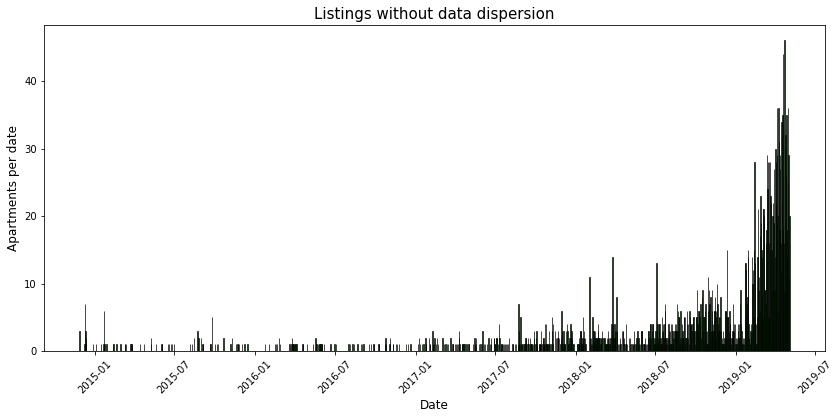

In [74]:
chart.reset_index(inplace=True)
grouped_data = chart.groupby('time_to_day').agg({'index': 'nunique'})

# Create the plot
plt.figure(figsize=(14, 6))  # Adjust the figure size if needed
plt.bar(grouped_data.index, grouped_data['index'], color='green', edgecolor='black', alpha=0.7)

# Customize the plot
plt.xlabel('Date', fontsize = 12)
plt.ylabel('Apartments per date', fontsize = 12)
plt.title('Listings without data dispersion', fontsize = 15)
plt.xticks(rotation=45)

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
We see dates all over the place but majority of listings are in 2018 - 2019 year range, which makes me think of hypothesis that we see here unsold items, therefore days_exposition constantly changing and to fix that, for our research we would add calculation based of last date where dataset was given - 2019-05-03

p.s. for future research, based on this theory we would add bool column Sold, where we determine this listings as unsold. </div>

In [75]:
import datetime as dt

In [76]:
days_difference = (pd.to_datetime('2019-05-03') - real['time_to_day']).dt.days
real['sold'] = real['days_exposition'].notnull().map({True: 'Yes', False: 'No'})
# Use .loc to fill missing values in 'days_exposition' column with the calculated values
real.loc[real.days_exposition.isna(), 'days_exposition'] = days_difference
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,sold
0,20,13000000,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,True,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,57.0,2019-03-07,No
1,7,3350000,40.4,2018-12-04T00:00:00,1,2.70,11.0,18.6,1,True,...,посёлок Шушары,12817.0,18603.0,0.0,612.0,0.0,729.0,81.0,2018-12-04,Yes
2,10,5196000,56.0,2015-08-20T00:00:00,2,2.60,5.0,34.3,4,True,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,2015-08-20,Yes
3,0,64900000,159.0,2015-07-24T00:00:00,3,3.14,14.0,95.0,9,True,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,2015-07-24,Yes
4,2,10000000,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,True,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,2018-06-19,Yes


In [77]:
real.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23592 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23592 non-null  int64         
 1   last_price            23592 non-null  int64         
 2   total_area            23592 non-null  float64       
 3   first_day_exposition  23592 non-null  object        
 4   rooms                 23592 non-null  int64         
 5   ceiling_height        23592 non-null  float64       
 6   floors_total          23592 non-null  float64       
 7   living_area           23592 non-null  float64       
 8   floor                 23592 non-null  int64         
 9   is_apartment          23592 non-null  bool          
 10  studio                23592 non-null  bool          
 11  open_plan             23592 non-null  bool          
 12  kitchen_area          23592 non-null  float64       
 13  balcony         

<div class="alert alert-block alert-info">
Number of values are the same in each column, now let`s finish this with alligning data types for each column for best research result.</div>

In [78]:
real['last_price'] = real['last_price'] / 1000
real['floors_total'] = real['floors_total'].astype(int)
real['airports_nearest'] = real['airports_nearest'].astype(int)
real['cityCenters_nearest'] = real['cityCenters_nearest'].astype(int)
real['parks_around3000'] = real['parks_around3000'].astype(int)
real['parks_nearest'] = real['parks_nearest'].astype(int)
real['ponds_around3000'] = real['ponds_around3000'].astype(int)
real['ponds_nearest'] = real['ponds_nearest'].astype(int)
real['days_exposition'] = real['days_exposition'].astype(int)

In [79]:
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,sold
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,Санкт-Петербург,18863,16028,1,482,2,755,57,2019-03-07,No
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,посёлок Шушары,12817,18603,0,612,0,729,81,2018-12-04,Yes
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,Санкт-Петербург,21741,13933,1,90,2,574,558,2015-08-20,Yes
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,Санкт-Петербург,28098,6800,2,84,3,234,424,2015-07-24,Yes
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,Санкт-Петербург,31856,8098,2,112,1,48,121,2018-06-19,Yes


<div class="alert alert-block alert-info">
We all set with cleaning and transforming our data for further research.</div>

<strong><em><h1>
Step 3. Calculation and Addition to the Table </em></strong></h1>

<div class="alert alert-block alert-info">
To make best of our research, we`ll add several calculated columns </div>

<h4><div class="alert alert-block alert-info">
Price per Square Meter.</div></h4>

In [80]:
real['price per sq m2, thousands'] = ((real['last_price']/real['total_area'])).round(1)
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,sold,"price per sq m2, thousands"
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,18863,16028,1,482,2,755,57,2019-03-07,No,120.4
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,12817,18603,0,612,0,729,81,2018-12-04,Yes,82.9
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,21741,13933,1,90,2,574,558,2015-08-20,Yes,92.8
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,28098,6800,2,84,3,234,424,2015-07-24,Yes,408.2
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,31856,8098,2,112,1,48,121,2018-06-19,Yes,100.0


<h4><div class="alert alert-block alert-info">
Day of the Week, Month, and Year of the Ad Publication.</div></h4>

In [81]:
real['weekday'] = real['time_to_day'].dt.weekday
real['month'] =real['time_to_day'].dt.month
real['year'] =real['time_to_day'].dt.year

In [82]:
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,time_to_day,sold,"price per sq m2, thousands",weekday,month,year
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,482,2,755,57,2019-03-07,No,120.4,3,3,2019
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,612,0,729,81,2018-12-04,Yes,82.9,1,12,2018
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,90,2,574,558,2015-08-20,Yes,92.8,3,8,2015
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,84,3,234,424,2015-07-24,Yes,408.2,4,7,2015
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,112,1,48,121,2018-06-19,Yes,100.0,1,6,2018


<h4><div class="alert alert-block alert-info">
Distribution of Floors into First, Last, and Other.</div></h4>

In [83]:
real['which_floor'] = np.where(real.floor == real.floors_total, 'последний',
         (np.where(real.floor == 1, 'первый', 'другой')))
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,time_to_day,sold,"price per sq m2, thousands",weekday,month,year,which_floor
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,2,755,57,2019-03-07,No,120.4,3,3,2019,другой
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,0,729,81,2018-12-04,Yes,82.9,1,12,2018,первый
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,2,574,558,2015-08-20,Yes,92.8,3,8,2015,другой
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,3,234,424,2015-07-24,Yes,408.2,4,7,2015,другой
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,1,48,121,2018-06-19,Yes,100.0,1,6,2018,другой


<h4><div class="alert alert-block alert-info">
Ratio of Living Area to Total Area and Ratio of Kitchen Area to Total Area.</div></h4>

In [84]:
real['living_to_total'] = (real['living_area'] / real['total_area']).round(2)
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_nearest,days_exposition,time_to_day,sold,"price per sq m2, thousands",weekday,month,year,which_floor,living_to_total
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,755,57,2019-03-07,No,120.4,3,3,2019,другой,0.47
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,729,81,2018-12-04,Yes,82.9,1,12,2018,первый,0.46
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,574,558,2015-08-20,Yes,92.8,3,8,2015,другой,0.61
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,234,424,2015-07-24,Yes,408.2,4,7,2015,другой,0.60
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,48,121,2018-06-19,Yes,100.0,1,6,2018,другой,0.32


In [85]:
real['kitchen_to_total'] = (real['kitchen_area'] / real['total_area']).round(2)
real.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,time_to_day,sold,"price per sq m2, thousands",weekday,month,year,which_floor,living_to_total,kitchen_to_total
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.70,16,51.0,8,True,...,57,2019-03-07,No,120.4,3,3,2019,другой,0.47,0.23
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.70,11,18.6,1,True,...,81,2018-12-04,Yes,82.9,1,12,2018,первый,0.46,0.27
2,10,5196.0,56.0,2015-08-20T00:00:00,2,2.60,5,34.3,4,True,...,558,2015-08-20,Yes,92.8,3,8,2015,другой,0.61,0.15
3,0,64900.0,159.0,2015-07-24T00:00:00,3,3.14,14,95.0,9,True,...,424,2015-07-24,Yes,408.2,4,7,2015,другой,0.60,0.09
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.03,14,32.0,13,True,...,121,2018-06-19,Yes,100.0,1,6,2018,другой,0.32,0.41


<strong><em><h1>
Step 4. Exploratory Data Analysis</em></strong></h1>

<h5><div class="alert alert-block alert-info">
Exploring Parameters: Area, Price, Number of Rooms, Ceiling Height:
Let's build a histogram for each parameter.</div></h5>

<h6><div class="alert alert-block alert-info">
Square footage
  </div></h6>

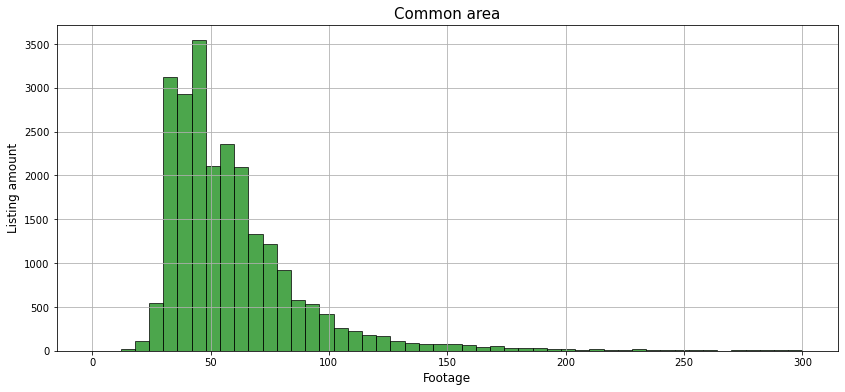

In [86]:

plt.figure(figsize=(14, 6)) 
real['total_area'].hist( range = (0, 300),bins = 50, color='green', edgecolor='black', alpha=0.7)

plt.xlabel('Footage', fontsize = 12)
plt.ylabel('Listing amount', fontsize = 12)
plt.title('Common area', fontsize = 15)

plt.show()


<div class="alert alert-block alert-info">
1) The total area is represented quite accurately - most of the apartments for sale are around 50 sqm, and apartments larger than 150 sqm are rare.
</div>

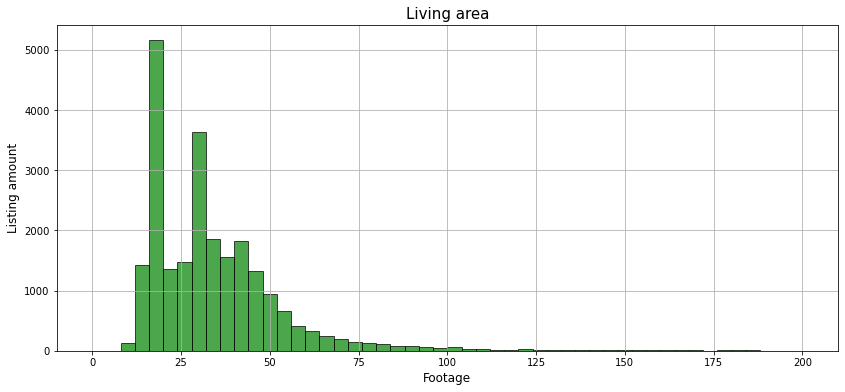

In [87]:
plt.figure(figsize=(14, 6)) 
real['living_area'].hist(range = (0, 200),bins = 50, color='green', edgecolor='black', alpha=0.7)
#plt.show('Жилая площадь')
plt.xlabel('Footage', fontsize =12)
plt.ylabel('Listing amount', fontsize = 12)
plt.title('Living area', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
2) There is a strange peak around 12 sqm - this is extremely small for an average 50 sqm apartment. The second peak around 30-32 sqm is more characteristic.
</div>

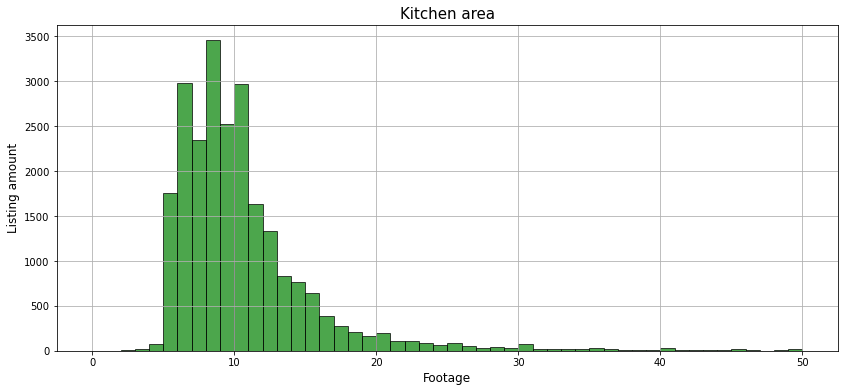

In [88]:
plt.figure(figsize=(14, 6)) 
real['kitchen_area'].hist(range = (0, 50),bins = 50, color='green', edgecolor='black', alpha=0.7 )
plt.xlabel('Footage', fontsize =12)
plt.ylabel('Listing amount' ,fontsize =12)
plt.title('Kitchen area', fontsize = 15)
plt.show()


<div class="alert alert-block alert-info">
3) The kitchen area histogram looks reasonable - there are several peaks associated with typical Soviet-era layouts where the area is precisely equal to certain standard values (7, 9, 12 sqm).</div>

<h4><div class="alert alert-block alert-info">
Publish to Sell time</div></h4>

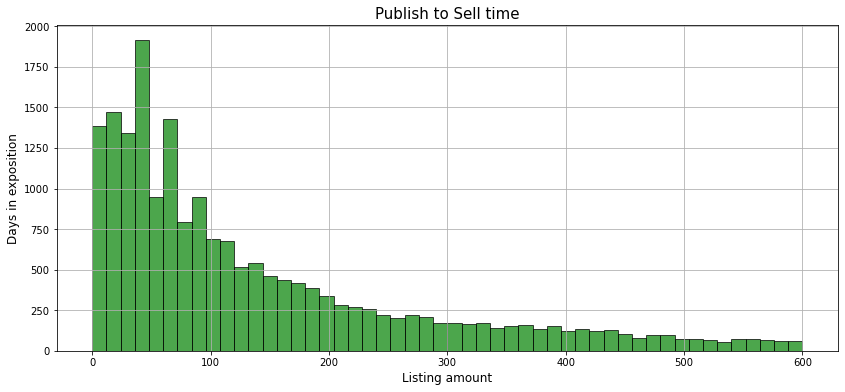

In [89]:
plt.figure(figsize=(14, 6)) 

real[real['sold'] == "Yes"]['days_exposition'].hist(range = (0,600), bins = 50, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Listing amount', fontsize = 12)
plt.ylabel('Days in exposition', fontsize = 12)
plt.title('Publish to Sell time', fontsize = 15)
plt.show()

In [90]:
sold_properties = real[real['sold'] == "Yes"]['days_exposition'].value_counts().reset_index()
sold_properties.rename(columns={'index': 'days_on_market', 'days_exposition': 'listing_amount'}, inplace=True)

sold_properties.sort_values(by = 'listing_amount', ascending = False)


,days_on_market,listing_amount
0,45,876
1,60,538
2,7,233
3,30,207
4,90,203
...,...,...
979,597,1
980,1572,1
981,1396,1
983,1268,1


<div class="alert alert-block alert-info">
Top-5 days dispersion tends to even numbers, or weekly basis. It looks more like agreed listing term had timed out and this listings were automatically deleted, so we cannot say for sure, that they were exactly sold. 
    
Lets compare with distribution of all the objects that we have in dataframe. 
</div>

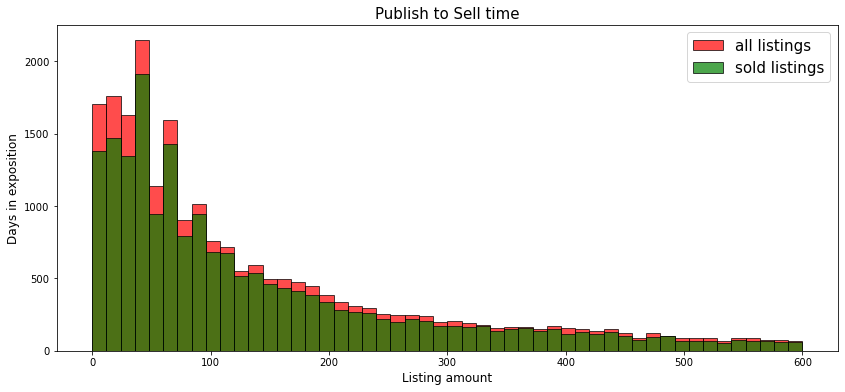

In [91]:
plt.figure(figsize=(14, 6)) 

potentially_sold = real[real['sold'] == "Yes"]['days_exposition'] 
common = real['days_exposition'] 
plt.hist(common, range = (0,600), bins = 50, color='red', edgecolor='black', alpha=0.7, label = "all listings")
plt.hist(potentially_sold, range = (0,600), bins = 50, color='green', edgecolor='black', alpha=0.7, label = "sold listings")

plt.xlabel('Listing amount', fontsize = 12)
plt.ylabel('Days in exposition', fontsize = 12)
plt.title('Publish to Sell time', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
In both cases dispersion look pretty much the same, so we can just implement days_exposition as market life of object without knowing whether it was sold or just deleted.  
</div>

In [92]:
real['days_exposition'].describe()

count    23592.000000
mean       185.759495
std        233.494503
min          0.000000
25%         43.000000
50%         94.000000
75%        237.000000
max       1618.000000
Name: days_exposition, dtype: float64

In [93]:
real['days_exposition'].median()

94.0

<div class="alert alert-block alert-info">
Based on the histogram, as well as looking at the mean and median values, I make the following observations:

1) The average selling time is 94 days or 3 months.

2) Extremely successful sales occur in less than 45 days, representing only 25% of the total sample.

3) There is a significant deviation between the mean value (172 days on the market) and the median value. This is likely due to a few excessively long selling periods.

4) Within 237 days or almost 8 months, 75% of real estate deals are completed, with the remaining being rare outliers.
</div>



<h4><div class="alert alert-block alert-info">
Removing Outliers.</div></h4>

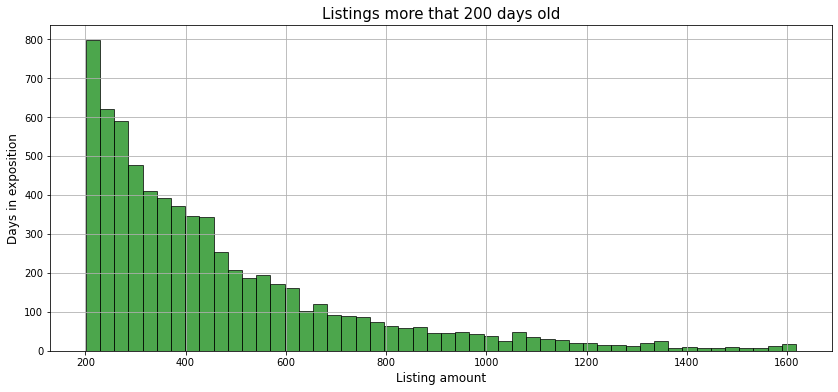

In [94]:
plt.figure(figsize=(14, 6)) 
real['days_exposition'][real['days_exposition'] > 200].hist( bins = 50, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Listing amount', fontsize = 12)
plt.ylabel('Days in exposition', fontsize = 12)
plt.title('Listings more that 200 days old', fontsize = 15)
plt.show()

In [95]:
real[real['days_exposition'] > 200]['days_exposition'].describe()

count    6866.000000
mean      464.613749
std       266.267063
min       201.000000
25%       272.000000
50%       383.000000
75%       562.000000
max      1618.000000
Name: days_exposition, dtype: float64

<div class="alert alert-block alert-info">
Any value greater than 562 days (1.5 years) should be considered an extreme outlier and should be removed from the dataset.

Now let`s check price dispersion. </div>

In [96]:
real['last_price'].describe()

count     23592.000000
mean       6525.303024
std       10815.096436
min          12.190000
25%        3418.750000
50%        4650.000000
75%        6799.250000
max      763000.000000
Name: last_price, dtype: float64

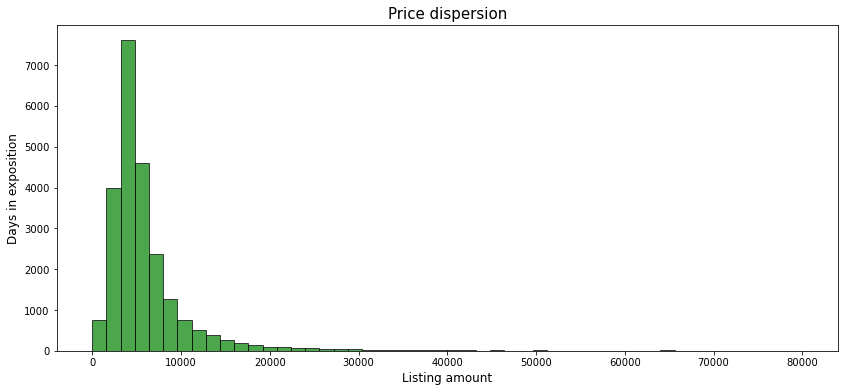

In [97]:
plt.figure(figsize=(14, 6)) 
plt.hist(real['last_price'], range = (0, 80000), bins = 50, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Listing amount', fontsize = 12)
plt.ylabel('Days in exposition', fontsize = 12)
plt.title('Price dispersion', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
Anything more than 15000 become extinctively rare.

Now let`s see proper room amount. </div>

In [98]:
real.rooms.describe()

count    23592.000000
mean         2.070193
std          1.072422
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         16.000000
Name: rooms, dtype: float64

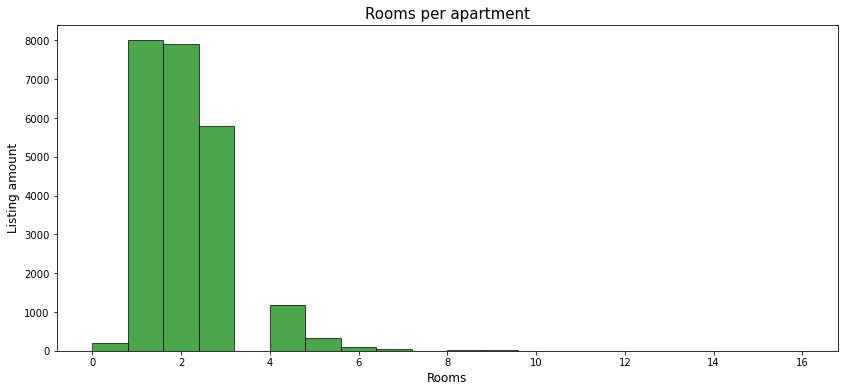

In [99]:
plt.figure(figsize=(14, 6)) 
plt.hist(real['rooms'], range = (0,16), bins = 20, color='green', edgecolor='black', alpha=0.7)
plt.xlabel('Rooms', fontsize = 12)
plt.ylabel('Listing amount', fontsize = 12)
plt.title('Rooms per apartment', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
You hardly ever get more that 4 rooms, and more that 6 is absolutely rare 

Let`s narrow down our dataframe to normal dispersion , no outlines. </div>

In [100]:
good_real = real.query('days_exposition < 400 and last_price > 2000 < 15000 and total_area > 20 < 400 and rooms <= 5')
len(good_real)

18993

In [101]:
good_real[['last_price', 'total_area','rooms', 'ceiling_height' ]].describe().loc[['min', 'max']]

,last_price,total_area,rooms,ceiling_height
min,2006.0,20.1,0.0,2.25
max,401300.0,500.0,5.0,4.90


<div class="alert alert-block alert-info">

Looks better </div>

<h3><div class="alert alert-block alert-info">
Studying Correlation</div></h3>

<h5><div class="alert alert-block alert-info">
Relation between Price and Area, Number of Rooms, and Proximity to the Center.</div></h5>

In [102]:
columns = ['last_price','rooms','total_area','cityCenters_nearest']
corr = pd.DataFrame(good_real, columns=columns)
corr.head()

,last_price,rooms,total_area,cityCenters_nearest
0,13000.0,3,108.0,16028
1,3350.0,1,40.4,18603
4,10000.0,2,100.0,8098
5,2890.0,1,30.4,16293
6,3700.0,1,37.3,19143


In [104]:
corr.corr()

,last_price,rooms,total_area,cityCenters_nearest
last_price,1.000000,0.333778,0.646616,-0.240273
rooms,0.333778,1.000000,0.731661,-0.139328
total_area,0.646616,0.731661,1.000000,-0.211015
cityCenters_nearest,-0.240273,-0.139328,-0.211015,1.000000


<Figure size 432x288 with 0 Axes>

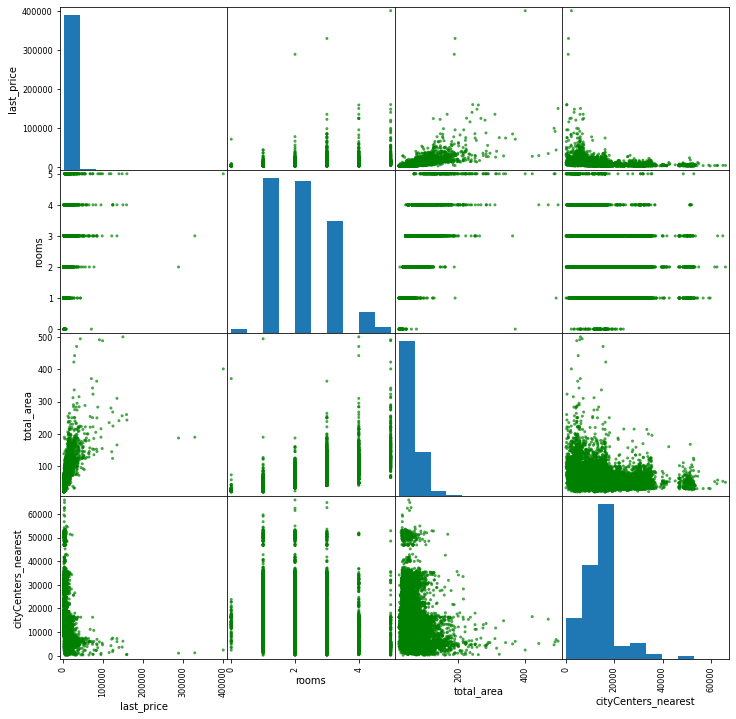

In [109]:
plt.gcf().set_facecolor('green')
pd.plotting.scatter_matrix(corr, figsize=(12, 12), color = 'green', alpha = 0.7)
plt.show()

<div class="alert alert-block alert-info">
After studying the correlation between price, the number of rooms, area, and proximity to the center, we observed the following:

1) There is a positive correlation between price and both area and the number of rooms, meaning that as the number of rooms or the area increases, the price also tends to increase.

2) The correlation with proximity to the center is predictably negative - higher prices are observed for apartments closer to the center, and interestingly, these apartments also tend to have larger areas.
</div>

<h6><div class="alert alert-block alert-info">
Dependency of Price on the Floor Level of the Apartment.
  </div></h6>

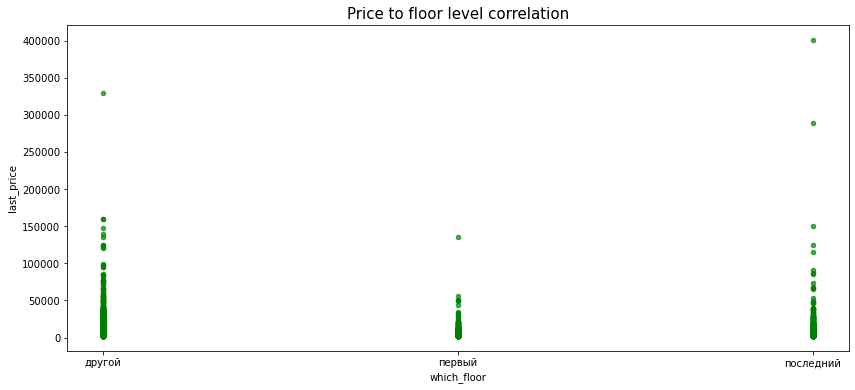

In [121]:
good_real.plot(y = 'last_price', x = 'which_floor', kind = 'scatter', color = 'green', alpha = 0.7, figsize=(14, 6))
plt.title ('Price to floor level correlation', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
Taking into account the current trends in high-rise construction, extraordinary prices are often found on the top floors, such as "penthouse" apartments. In general, higher prices are observed on the middle floors, while prices on the first floor are significantly lower.
</div>


<h6><div class="alert alert-block alert-info">
Dependency on the Date of Listing:
  </div></h6>

<h6><div class="alert alert-block alert-info">
Day of the Week:
  </div></h6>

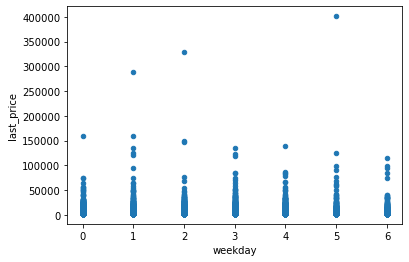

0.0012405294557999015

In [123]:
good_real.plot(y = 'last_price', x = 'weekday', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['weekday'])

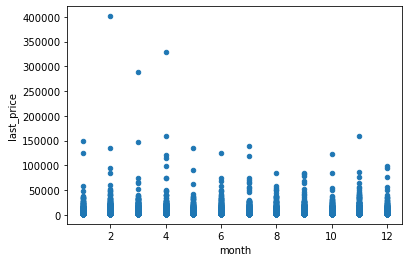

-0.011674832492520576

In [124]:
good_real.plot(y = 'last_price', x = 'month', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['month'])

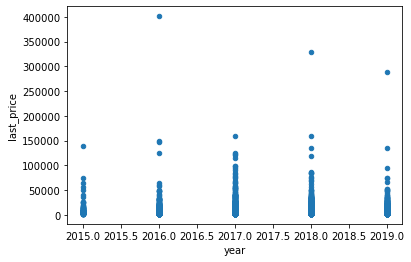

0.0016929484738665587

In [125]:
good_real.plot(y = 'last_price', x = 'year', kind = 'scatter')
plt.show()
good_real['last_price'].corr(good_real['year'])

<div class="alert alert-block alert-info">
Regarding the day of the week, there is no significant correlation between the listing day and the price.

The same can be said for the months, contrary to the common belief in seasonal price variations.

However, the annual correlation clearly shows that prices were at their highest in 2017 compared to previous and subsequent years, and now there is a downward trend.
</div>

<h6><div class="alert alert-block alert-info">
Average Price and Price per Square Meter in the 10 Largest Cities
  </div></h6>

In [126]:
local_name = good_real.pivot_table(
    index='locality_name', values='last_price', aggfunc='count'
)
local_name.columns = ['count']

good_names = local_name.query('count >= 175')
good_names['count'].sum()



15933

In [127]:
top10towns = good_real.query('locality_name in @good_names.index')
top10towns

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,days_exposition,time_to_day,sold,"price per sq m2, thousands",weekday,month,year,which_floor,living_to_total,kitchen_to_total
0,20,13000.0,108.0,2019-03-07T00:00:00,3,2.700,16,51.0,8,True,...,57,2019-03-07,No,120.4,3,3,2019,другой,0.47,0.23
1,7,3350.0,40.4,2018-12-04T00:00:00,1,2.700,11,18.6,1,True,...,81,2018-12-04,Yes,82.9,1,12,2018,первый,0.46,0.27
4,2,10000.0,100.0,2018-06-19T00:00:00,2,3.030,14,32.0,13,True,...,121,2018-06-19,Yes,100.0,1,6,2018,другой,0.32,0.41
6,6,3700.0,37.3,2017-11-02T00:00:00,1,2.650,26,10.6,6,True,...,155,2017-11-02,Yes,99.2,3,11,2017,другой,0.28,0.39
7,5,7915.0,71.6,2019-04-18T00:00:00,2,2.775,24,44.3,22,True,...,15,2019-04-18,No,110.5,3,4,2019,другой,0.62,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23686,8,3300.0,31.0,2017-04-29T00:00:00,1,2.550,9,18.0,6,True,...,193,2017-04-29,Yes,106.5,5,4,2017,другой,0.58,0.21
23687,6,3200.0,39.0,2017-12-16T00:00:00,1,2.650,9,20.0,6,True,...,38,2017-12-16,Yes,82.1,5,12,2017,другой,0.51,0.28
23688,19,9200.0,101.0,2019-04-01T00:00:00,3,3.050,15,63.0,12,True,...,23,2019-04-01,Yes,91.1,0,4,2019,другой,0.62,0.15
23689,13,3550.0,35.3,2018-02-28T00:00:00,1,2.860,15,16.3,4,True,...,29,2018-02-28,Yes,100.6,2,2,2018,другой,0.46,0.26


In [131]:
columns = ['locality_name','last_price', 'price per sq m2, thousands']
most_expensive = pd.DataFrame(top10towns, columns = columns )
most_expensive

,locality_name,last_price,"price per sq m2, thousands"
0,Санкт-Петербург,13000.0,120.4
1,посёлок Шушары,3350.0,82.9
4,Санкт-Петербург,10000.0,100.0
6,посёлок Парголово,3700.0,99.2
7,Санкт-Петербург,7915.0,110.5
...,...,...,...
23686,Санкт-Петербург,3300.0,106.5
23687,Санкт-Петербург,3200.0,82.1
23688,Санкт-Петербург,9200.0,91.1
23689,Санкт-Петербург,3550.0,100.6


In [132]:
most_expensive2 = most_expensive.pivot_table(index = 'locality_name', values = ('last_price','price per sq m2, thousands'), aggfunc = 'mean')
#most_expensive2.columns ( columns = ['last_price', 'square_metr'])
most_expensive2.sort_values(by = 'last_price', ascending = False).round(0)

,last_price,"price per sq m2, thousands"
locality_name,,
Санкт-Петербург,7237.0,113.0
Пушкин,5972.0,103.0
посёлок Парголово,4517.0,90.0
деревня Кудрово,4286.0,93.0
посёлок Шушары,4108.0,79.0
Всеволожск,3941.0,70.0
Колпино,3839.0,75.0
посёлок Мурино,3694.0,86.0
Гатчина,3568.0,71.0


<div class="alert alert-block alert-info">
Predictably, the most expensive place to buy property is St. Petersburg. Next comes Pushkin city, and in third place is a settlement.

Among the top cities, Vyborg city has the lowest prices, with prices being half of those in St. Petersburg.
</div>

In [134]:
import warnings

warnings.filterwarnings('ignore')
piter = good_real.query('locality_name == "Санкт-Петербург"')
piter['cityCenters_nearest_km'] = (piter['cityCenters_nearest']/ 1000).round(0)
center = piter.pivot_table(index = 'cityCenters_nearest_km', values = 'last_price', aggfunc = 'mean')
center

,last_price
cityCenters_nearest_km,
0.0,30303.761905
1.0,21693.011467
2.0,15311.018802
3.0,9953.408725
4.0,11348.981324
5.0,12041.442145
6.0,12808.468025
7.0,12642.226921
8.0,8684.547103


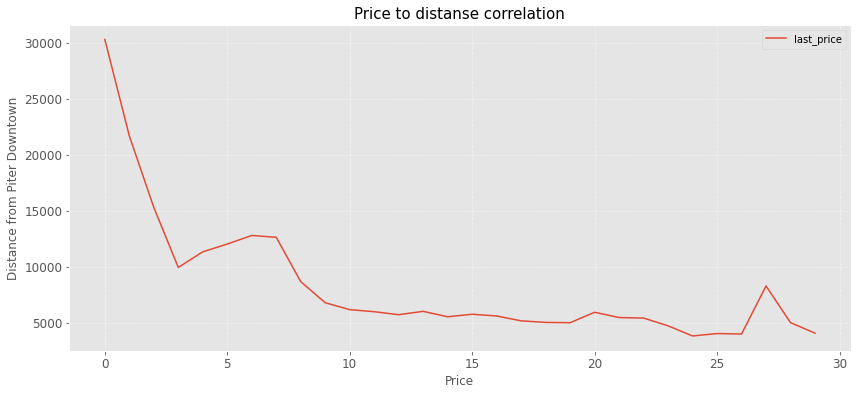

In [140]:
#plt.figure(figsize=(14, 6))  # Set the figure size (width, height) in inches
plt.style.use('ggplot')      # Use the 'ggplot' style, which is visually appealing

# Plot the data from the 'center' DataFrame
center.plot(figsize=(14, 6))

# Add labels and title
plt.xlabel('Price', fontsize=12)
plt.ylabel('Distance from Piter Downtown', fontsize=12)
plt.title('Price to distanse correlation', fontsize=15)

# Customize ticks and tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Customize legend
#plt.legend(fontsize=12)

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
Based on the graph, it appears that the radius of the center in St. Petersburg is around 3 km. After this point, there is an interesting price jump at around 7 km, and then prices decrease significantly.

For residential real estate, the immediate city center may not be the best place to live. This could be explained by the presence of elite developments slightly further away but still conveniently accessible.
</div>

<h6><div class="alert alert-block alert-info">
Studying the Segment of Apartments in the Center of St. Petersburg
  </div></h6>

In [141]:
piter_center = piter.query('cityCenters_nearest_km <= 3')
piter_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 618 entries, 24 to 23602
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   total_images                618 non-null    int64         
 1   last_price                  618 non-null    float64       
 2   total_area                  618 non-null    float64       
 3   first_day_exposition        618 non-null    object        
 4   rooms                       618 non-null    int64         
 5   ceiling_height              618 non-null    float64       
 6   floors_total                618 non-null    int64         
 7   living_area                 618 non-null    float64       
 8   floor                       618 non-null    int64         
 9   is_apartment                618 non-null    bool          
 10  studio                      618 non-null    bool          
 11  open_plan                   618 non-null    bool       

In [142]:
columns = ['total_area','rooms', 'last_price','ceiling_height','floor','cityCenters_nearest_km','time_to_day']
piter_center2 = pd.DataFrame(piter_center, columns = columns)
piter_center2

,total_area,rooms,last_price,ceiling_height,floor,cityCenters_nearest_km,time_to_day
24,97.2,2,6500.0,2.725,1,2.0,2015-10-31
99,90.0,4,9600.0,2.800,2,3.0,2017-09-26
138,40.0,2,4800.0,2.700,2,3.0,2017-11-18
154,80.0,3,8200.0,4.150,2,3.0,2018-11-06
179,108.7,3,14800.0,4.000,5,3.0,2019-04-11
...,...,...,...,...,...,...,...
23369,129.0,3,20900.0,3.020,7,2.0,2016-05-13
23387,50.0,1,5600.0,2.600,1,3.0,2017-08-21
23399,97.0,3,15300.0,3.500,2,1.0,2017-01-11
23430,38.0,1,5260.0,3.300,1,3.0,2018-11-06


<div class="alert alert-block alert-info">
Let's study the total area represented in the center.
</div>

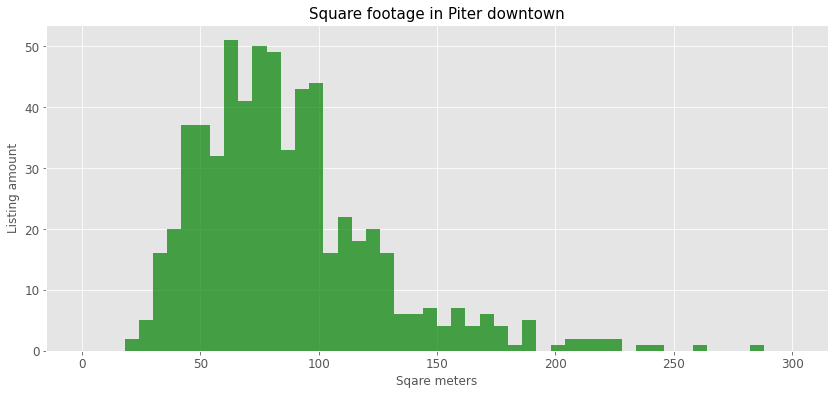

In [146]:
piter_center2['total_area'].hist( range = (0, 300),bins = 50, figsize=(14, 6), color = 'green', alpha = 0.7)
plt.title('Square footage in Piter downtown', fontsize = 15)
plt.xlabel('Sqare meters', fontsize=12)
plt.ylabel('Listing amount', fontsize=12)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [147]:
piter_center2['total_area'].describe()

count    618.000000
mean      87.803528
std       43.064581
min       22.700000
25%       60.000000
50%       79.800000
75%      102.300000
max      401.000000
Name: total_area, dtype: float64

<div class="alert alert-block alert-info">
Contrary to expectations of a large number of small-sized investment properties, the largest number of apartments have a total area ranging from 70 to 100 square meters.

Now let's see how this total area corresponds to the number of rooms.
</div>

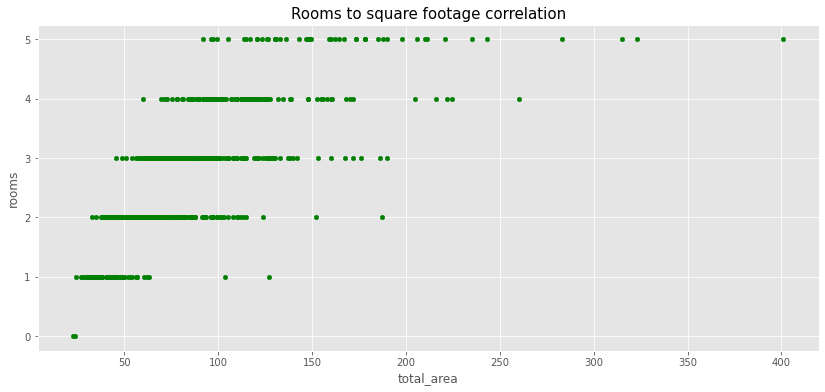

In [152]:
piter_center2.plot(y = 'rooms', x = 'total_area', kind = 'scatter', figsize = (14,6), color = 'green')
plt.title('Rooms to square footage correlation', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
Once again, we can see from the graph that 3 and 4-room apartments with larger total areas are predominant. This might be attributed to the legacy of past times with aristocratic ambitions and spacious living preferences.
</div>

<div class="alert alert-block alert-info">
Let's examine how the price depends on the proximity to the central point, the "zero" kilometer.
</div>

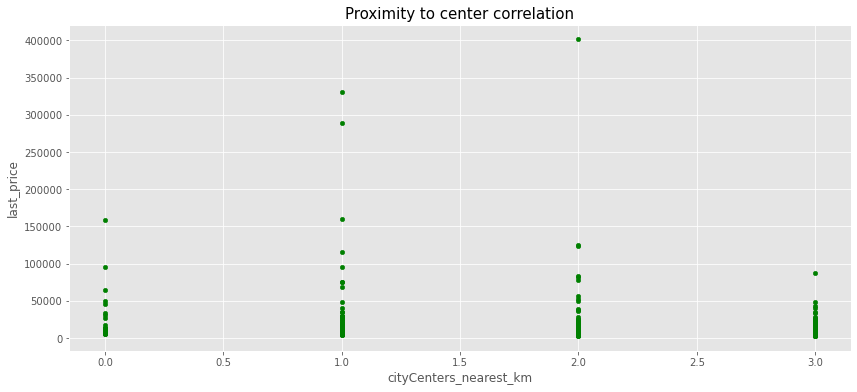

In [154]:
piter_center2.plot(y = 'last_price', x = 'cityCenters_nearest_km', kind = 'scatter', figsize = (14,6), color = 'green')
plt.title('Proximity to center correlation', fontsize = 15)
plt.show()

<div class="alert alert-block alert-info">
As we can see, the price distribution is approximately similar at any kilometer distance from the center. The central area remains the center regardless of the specific distance from the central point.
</div>


<div class="alert alert-block alert-info">
The center is known for its high ceilings, which are often considered a prestigious element. Let's see if this is indeed the case.
</div>

In [ ]:
piter_center2['ceiling_height'].hist( range = (0, 6),bins = 30)
plt.show()



In [ ]:
piter_center2.plot(y = 'last_price', x = 'ceiling_height', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
На гистограмме имеется 2 характерных пика - на отметке типовых 2.7м, которые скорее всего относятся к более современным постройкам, и чуть больше 3метров (3.10-3.30м) которые отражают сталинские и довоенные дома.
    
Что касается корреляции с ценой, то потолок не является определяющим фактором цены. Место, место и ещё раз место.
</div>

<div class="alert alert-block alert-info">
Отношение цены и этажа квартиры.
</div>

In [ ]:
piter_center2.plot(y = 'last_price', x = 'floor', kind = 'scatter')
plt.show()

<div class="alert alert-block alert-info">
Как видим из результата, высоких зданий в центре практически нет и каждый ценит свой - кто-то первый для бизнеса, кому-то легче на второй подниматься, а выше 4-ого - уже "видовые".
</div>

<h7><div class="alert alert-block alert-info">
Изменение цены во времени
  </div></h7>

<h7><div class="alert alert-block alert-info">
Среди факторов теоретически влияющих на стоимость объекта в центре мы отмели высоту потолков и увеличение цены по мере приближения к центральной точке. Но как насчет поверья, что недвижимость в центре только дорожает?
  </div></h7>

In [ ]:
piter_center2.plot(y = 'last_price', x = 'time_to_day')
good_real.plot(y = 'last_price', x = 'time_to_day')
plt.show()

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Такой график получился из-за большого числа значений. Тут можно построить точечную диаграмму или же график прямой, который покажет зависимость медианы цены от даты размещения.</div>

<h7><div class="alert alert-block alert-info">
Как и в целом по рынку, основной пик был в середине 2017 и затем цены немного снизились, за исключением нескольких экстраординарных сделок.
  </div></h7>

 <strong><em><h1>
Шаг 5 общие выводы. </em></strong></h1>

<h7><div class="alert alert-block alert-info">
На удивление мало факторов влияет на стоимость объекта недвижимости по-настоящему.
Первый фактор это месторасположение. Питер стоит значительно дороже пригорода, центр превосходит любой спальный район.
Второй фактор это общее экономическое положение, как внешний фактор. Если есть спрос, то он влияет на все цены, если спроса нет, то цена падает на всю недвижимость и этажность, площадь и тому подобное не влияет.

  </div></h7>

<div class="alert alert-warning" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid">
<h2> Комментарий ревьюера 2</h2>
    
Вывод хороший. В идеале стоит подкреплять его полученными ранее результаты. Здесь же можно добавить медианы основных характеристик квартир для центра и для всей выборки, чтобы заказчику было понятно не только то, что квартиры в центре больше и дороже, но и насколько они больше и насколько дороже.
</div>